# Le chemin des solutions de l'estimateur SLOPE

In [49]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt

### Notions liées à l'estimateur SLOPE

**La norme $\ell_1$ ordonnée :**
 $J_\lambda(b)=\sum_{i=1}^{p}\lambda_i|b|_{\downarrow i}$


In [50]:
def sorted_L1_norm(b,Lambda):
    b = - np.sort(-np.abs(b))  
    return np.sum(Lambda*b)

**La norme $\ell_1$ ordonée duale :**   
$$ J^*_\lambda(v)=\max\left\{\frac{\|v\|_{(1)}} 
{\lambda_1},\frac{\|v\|_{(2)}}{\sum_{i=1}^{2}\lambda_i},\ldots,\frac{\|v\|_{(p)}}{\sum_{i=1}^{p}\lambda_i}\right\}
$$

In [51]:
def dual_sorted_L1_norm(v,Lambda):
    v = - np.sort(-np.abs(v)) 
    v_cum = np.cumsum(v)  
    Lambda_cum = np.cumsum(Lambda) 
    return np.max(v_cum/Lambda_cum)

**Le schéma du SLOPE ${\rm schm}(b)$ pour $b\in \mathbb{R}^p$ :**

In [52]:
def pattern(b, tol=1e-10):
    sign = np.sign(b)
    perm = np.argsort(-np.abs(b))
    b = np.abs(b)[perm]
    epsilon = min(tol*(b[0]-b[-1])/len(b), tol)
    jump = b - np.append(b[1:],0) > epsilon
    q = np.flip(np.cumsum(np.flip(jump)))
    m = np.empty_like(b, dtype=int)
    m[perm] = q * sign[perm]
    return m

**La matrice du schéma $U_m$ pour $m\in \mathcal{P}^{\rm slope}_p$:**

In [53]:
def pattern_matrix(m):
    k = int(np.linalg.norm(m, ord=np.inf))
    U_m = np.empty((len(m),k))
    for j in range(k):
        U_m[:,j] = np.sign(m)*(np.abs(m) == k-j) 
    return U_m

###  Algorithmes 1 et 2

**Algorithme 1 :** 

In [54]:
def face_pattern(z, Lambda, tol=1e-10):
    z = z / dual_sorted_L1_norm(z,Lambda)  
    sign = np.sign(z)
    perm = np.argsort(-np.abs(z))
    z = np.abs(z)[perm]
    r = np.cumsum(z) / np.cumsum(Lambda)
    l = np.isclose(r, 1, rtol=tol)
    q = np.flip(np.cumsum(np.flip(l))) 
    m = np.empty_like(z, dtype=int)
    m[perm] = q * sign[perm]
    return m

**Algorithme 2:**

In [55]:
def affine_components(X, y, Lambda, m):
    X_tilde = X @ pattern_matrix(m) 
    m = - np.sort(-np.abs(m)) 
    Lambda_tilde = pattern_matrix(m).T @ Lambda
    P = X_tilde.T @ X_tilde
    a_s = - np.linalg.solve(P, Lambda_tilde)
    b_s = np.linalg.solve(P, X_tilde.T @ y)
    a_g = - X.T @ X_tilde @ a_s
    b_g = X.T @ (y - X_tilde @ b_s)
    return a_s, b_s, a_g, b_g

#######################################################################################

def gamma_fuse(a_s, b_s, gamma, gamma_min = 0, tol=1e-10):
    a = np.append(a_s, 0)
    b = np.append(b_s, 0)
    Gamma = - (b[1:]- b[:-1]) / (a[1:] - a[:-1])
    epsilon = tol*(gamma+1)
    return np.max(Gamma[(0 < Gamma) & (Gamma < gamma - epsilon)], initial=gamma_min)

#######################################################################################

def gamma_split(a_g, b_g, gamma_left, gamma_right, Lambda, tol=1e-10, count_max=1e2):
    K = np.array([True]); count = 0
    L_cum = np.cumsum(Lambda)
    while K.any() and count < count_max:
        count += 1
        g = a_g * gamma_left + b_g 
        sign = np.sign(g)
        perm = np.argsort(-np.abs(g))
        A_cum = np.cumsum(sign[perm]*a_g[perm])
        B_cum = np.cumsum(sign[perm]*b_g[perm])
        epsilon=tol*(gamma_left+1)
        K = A_cum * gamma_left + B_cum - L_cum * gamma_left > epsilon
        gamma_left = min(np.max(B_cum[K] / (L_cum[K] - A_cum[K]), initial=gamma_left), gamma_right)
        if count > count_max:
            print("attention : noeuds adjacent trop proche")
    return gamma_left, count > 1

#######################################################################################

def pattern_kinks(X, y, Lambda, ratio=1e-2, k_max=1e3, tol=1e-10):
    t_in = time.time()
    grad = X.T @ y
    gamma = dual_sorted_L1_norm(grad, Lambda); Gamma = [gamma]
    m = face_pattern(grad, Lambda, tol); M = [m]
    t_out = time.time(); T = [t_out - t_in]
    gamma_min = ratio*gamma; k = 0; Split = [True]
    while gamma > gamma_min and k < k_max:
        k += 1
        a_s,b_s,a_g,b_g = affine_components(X, y, Lambda, m)
        gamma_f = gamma_fuse(a_s, b_s, gamma, gamma_min, tol)
        gamma_s, split = gamma_split(a_g, b_g, gamma_f, gamma, Lambda, tol)
        if gamma_s > gamma - tol:
            print("attention : noeuds adjacent trop proche")
            break
        if split:
            gamma = gamma_s
            grad = a_g * gamma + b_g
            m = face_pattern(grad, Lambda, tol)
            t_out = time.time()
        else:
            gamma = gamma_f
            s = a_s * gamma + b_s
            z = pattern_matrix(m) @ s
            m = pattern(z, tol)
            t_out = time.time()
        Gamma.append(gamma)
        M.append(m)
        T.append(t_out - t_in)
        Split.append(split)
    return Gamma, M, T, Split

**Chemin des solutions de l'estimateur SLOPE :** à partir des noeuds $\gamma_0>\dots>\gamma_{r+1}=0$ et des schémas
$m^{(0)},\dots,m^{(r)}$ le calcul du chemin des solutions de l'estimateur SLOPE s'effectue via le code suivant  

In [56]:
def solution_SLOPE(X, y, Lambda, Gamma, M):
    Sol = [np.zeros(X.shape[1])]
    for k, gamma in enumerate(Gamma[1:]):
        m = M[k] 
        a_s,b_s, *_ = affine_components(X, y, Lambda, m)
        s = a_s * gamma + b_s
        sol = pattern_matrix(m) @ s
        Sol.append(sol)
    return Sol

### Chemin des solutions de l'estimateur SLOPE donné à l'exemple 3.

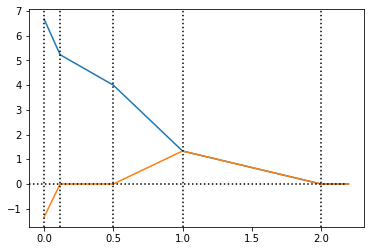

In [57]:
X=np.array([[1,0.5],[0.5,1]])
Lambda = np.array([4,2])
y = np.array([6,2])

# Calcul des noeuds et schéma
Gamma, M, T, Split = pattern_kinks(X, y , Lambda, ratio=0)

# Calcul des solutions aux noeuds 
Sol = solution_SLOPE(X, y, Lambda, Gamma, M)

# Représente le chemin des solutions 
fig, ax = plt.subplots()
ax.plot([1.1*Gamma[0]] + Gamma, [Sol[0]] + Sol)
for gamma in Gamma:
    ax.axvline(gamma, color='k', linestyle=':')
ax.axhline(0, color='k', linestyle=':', xmax=0.95)
plt.show() 

### Algorithme d'homothopie pour le calcul du chemin des solutions de l'estimateur LASSO

In [58]:
def affine_components_LASSO(X, y, s):
    I=s!=0
    P=np.transpose(X[:,I])@X[:,I]
    B=np.transpose(X[:,I])@y
    A=-s[I]
    b_s=np.linalg.solve(P,B)
    a_s=np.linalg.solve(P,A)
    a_g = - X.T @ X[:,I] @ a_s
    b_g = X.T @ (y - X[:,I] @ b_s)
    return a_s, b_s, a_g, b_g

#######################################################################################

def gamma_zero(a_s, b_s, gamma, tol=1e-10):
    epsilon=tol*(gamma+1)
    vanish=-b_s/a_s
    return np.max(vanish[(0 < vanish) & (vanish < gamma - epsilon)], initial=0)

#######################################################################################

def gamma_gradient(a_g, b_g, gamma, tol=1e-10):
    K = np.array([True]); count = 0
    while K.any():
        count +=1
        g = a_g * gamma + b_g 
        sign = np.sign(g)
        K = np.abs(g) > gamma + tol*(gamma+1) 
        gamma=np.max(b_g[K] / ( sign[K]-a_g[K]), initial=gamma)
    return gamma, count > 1

######################################################################################

def pattern_kinks_LASSO(X, y, k_max=1e2, tol=1e-10):
    t_in = time.time()
    grad = X.T @ y
    gamma = np.linalg.norm(grad,ord=np.inf); Gamma = [gamma]
    s=np.repeat(0,X.shape[1])
    s[np.transpose(X)@y>gamma*(1-tol)]=1
    s[np.transpose(X)@y<-gamma*(1-tol)]=-1
    S=[s]
    t_out = time.time(); T = [t_out - t_in]
    k = 0
    while gamma>0 and k < k_max:
        k += 1
        a_s,b_s,a_g,b_g = affine_components_LASSO(X, y, s)
        gamma_z = gamma_zero(a_s, b_s, gamma)
        gamma_g, enter = gamma_gradient(a_g, b_g, gamma_z)
        if enter:
            gamma = gamma_g
            grad = a_g * gamma + b_g
            s = np.repeat(0,X.shape[1])
            s[grad>gamma*(1-tol)]=1
            s[grad<-gamma*(1-tol)]=-1
            t_out = time.time()
        else:
            gamma = gamma_z
            sol_support = a_s * gamma + b_s
            epsilon=tol*(1+np.linalg.norm(sol_support,ord=np.inf))
            sol_support[np.abs(sol_support)<tol]=0
            I=s!=0
            s=np.repeat(0,X.shape[1])
            s[I]=np.sign(sol_support)
            t_out = time.time()
        Gamma.append(gamma)
        S.append(s)
        T.append(t_out - t_in)
    return Gamma, S, T

def solution_LASSO(X, y, Gamma, S):
    Sol = [np.zeros(X.shape[1])]
    for k, gamma in enumerate(Gamma[1:]):
        s = S[k] 
        a_s,b_s, *_ = affine_components_LASSO(X, y, s)
        I=s!=0
        sol=np.zeros(X.shape[1],dtype=float)
        sol[I] = a_s * gamma + b_s
        Sol.append(sol)
    return Sol

In [59]:
from sklearn.datasets import load_boston
boston = load_boston()
X=boston.data
y=boston.target

# Normalisation des données
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X = (X - X_mean) / X_std

y_mean = np.mean(y)
y = y - y_mean

# Séparer les données en ensemble d'apprentissage Xapp, yval et ensemble de validation Xval, yval
Xapp = X[:400,:]
yapp = y[:400]
Xval = X[400:,:]
yval = y[400:]

### Chemins des solutions des estimateurs SLOPE et LASSO appliqués aux données « Boston Housing »

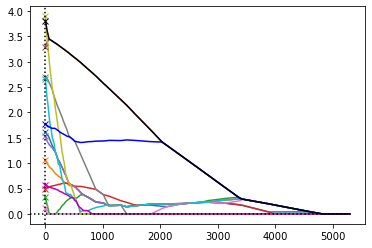

In [60]:
# Le paramètre de pénalité de l'estimateur SLOPE est 
Lambda=np.sqrt(range(1,14))-np.sqrt(range(0,13))

# Calcul des noeuds et schémas
Gamma, M, T, Split = pattern_kinks(Xapp, yapp, Lambda, ratio=0)


# Calcul du chemins des solutions du SLOPE et des composantes des moindres carrés en valeur absolue. 
Sol = solution_SLOPE(Xapp, yapp, Lambda, Gamma, M)

Sol_abs = [np.abs(sol) for sol in Sol]
ols = np.linalg.solve(Xapp.T@Xapp, Xapp.T@yapp)
ols_abs = np.abs(ols)

from cycler import cycler
plt.rcParams['axes.prop_cycle'] = cycler('color', ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
                                                   '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf','b','m','k'])

plt.plot([1.1*Gamma[0]] + Gamma, [Sol[0]] + Sol_abs)
plt.plot(0, [ols_abs], 'x')
plt.axvline(0, color='k', linestyle=':')
plt.axhline(0, color='k', linestyle=':', xmax=0.95)
plt.show()

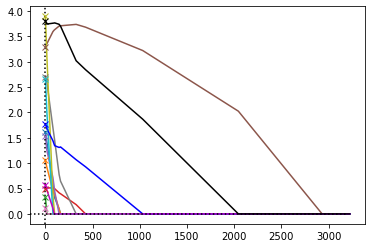

In [61]:
Gamma, S, *_ = pattern_kinks_LASSO(Xapp, yapp)

# Calcul du chemins des solutions du LASSO et des composantes des moindres carrés en valeur absolue
Sol = solution_LASSO(Xapp, yapp, Gamma, S)
Sol_abs = [np.abs(sol) for sol in Sol]
ols = np.linalg.solve(Xapp.T@Xapp, Xapp.T@yapp)
ols_abs = np.abs(ols)

plt.plot([1.1*Gamma[0]] + Gamma, [Sol[0]] + Sol_abs)
plt.axvline(0, color='k', linestyle=':')
plt.axhline(0, color='k', linestyle=':', xmax=0.95)
plt.plot(0, [np.abs(ols)], 'x')
plt.show()

### Minimisation de la somme des carrés résiduels 

**Somme des carrés résiduels :** 

In [62]:
def SCRV(Xval,yval,Sol):
    return(np.linalg.norm(yval-Xval @ Sol, ord=2)**2)

In [63]:
zero_estimator = np.zeros(X.shape[1])
print(SCRV(Xval,yval,zero_estimator))
ols_app = np.linalg.solve(Xapp.T@Xapp, Xapp.T@yapp)
print(SCRV(Xval,yval,ols_app))

7895.051474323932
2641.6279680942725


***Minimisation de la somme des carrés résiduels :*** le code suivant permet de minimiser la somme des carrés résiduels sur l'échantillon de validation de l'estimateur SLOPE 

In [64]:
def critical_points(Xval,yval,m,a_s,b_s):
    Xvaltilde = Xval @ pattern_matrix(m)
    N=np.transpose(a_s) @ np.transpose(Xvaltilde) @ (yval -Xvaltilde @ b_s)
    D=np.linalg.norm(Xvaltilde @ a_s, ord=2)**2
    c=N/D
    return(c)

def min_SCR(Xapp,yapp,Xval,yval,Lambda,Gamma,M):
    SCR=list()
    Critical = list()
    Solution = list()
    kmax=len(Gamma)-1  
    for k in range(kmax):
        m = M[k] 
        a_s,b_s, *_ = affine_components(Xapp, yapp, Lambda, m)
        c=critical_points(Xval, yval, m, a_s, b_s)
        gamma_0=Gamma[k]
        gamma_1=Gamma[k+1]
        Sol0=pattern_matrix(m) @ (a_s * gamma_0 + b_s )
        scr=SCRV(Xval,yval,Sol0)
        SCR.append(scr)
        Critical.append(gamma_0)
        Solution.append(Sol0)
        Sol1=pattern_matrix(m) @ (a_s * gamma_1 + b_s ) 
        if c<gamma_0 and c>gamma_1:
            a= (c-gamma_1)/(gamma_0-gamma_1)
            Solc=a*Sol0+(1-a)*Sol1
            scr=SCRV(X,y,Solc)
            SCR.append(scr)
            Critical.append(c)
            Solution.append(Solc)
    m = M[-1]
    a_s,b_s, *_ = affine_components(Xapp, yapp, Lambda, m)
    gamma_0=Gamma[-1]
    Sol0=pattern_matrix(m) @ (a_s * gamma_0 + b_s )
    scr=SCRV(Xval,yval,Sol0)
    SCR.append(scr)
    Critical.append(gamma_0)
    Solution.append(Sol0)
    return Critical, SCR, Solution

In [65]:
Lambda=np.sqrt(range(1,X.shape[1]+1))-np.sqrt(range(0,X.shape[1]))

Gamma, M, T, Split = pattern_kinks(Xapp, yapp, Lambda, ratio=0)
C,S,Solution = min_SCR(Xapp, yapp, Xval,yval,Lambda,Gamma,M)   

i0=np.argmin(S)
print(S[i0])
print(C[i0])     
print(Solution[i0])  
print(pattern(Solution[i0]))

2159.045472692249
357.38588754081786
[-0.75067428  0.60605446 -0.2459192   0.60605446 -0.75067428  3.21594712
  0.         -1.70945109  0.75067428 -0.4161687  -1.54307232  0.38658049
 -3.21594712]
[-5  4 -1  4 -5  8  0 -7  5 -3 -6  2 -8]


***Minimisation de la somme des carrés résiduels :*** le code suivant permet de minimiser la somme des carrés résiduels sur l'échantillon de validation de l'estimateur LASSO

In [66]:
def critical_points_LASSO(Xval,yval,s,a_s,b_s):
    I=s!=0
    N=np.transpose(a_s) @ np.transpose(Xval[:,I]) @ (yval -Xval[:,I] @ b_s)
    D=np.linalg.norm(Xval[:,I] @ a_s, ord=2)**2
    c=N/D
    return(c)

def min_SCR_LASSO(Xapp,yapp,Xval,yval,Gamma,S):
    SCR=list()
    Critical = list()
    Solution = list()
    kmax=len(Gamma)-1  
    for k in range(kmax):
        s = S[k] 
        a_s,b_s, *_ = affine_components_LASSO(Xapp, yapp, s)
        c = critical_points_LASSO(Xval, yval, s, a_s, b_s)
        gamma_0=Gamma[k]
        gamma_1=Gamma[k+1]
        Sol0 = np.zeros(X.shape[1],dtype=float)
        Sol1 = np.zeros(X.shape[1],dtype=float)
        I=s!=0
        Sol0[I] = a_s * gamma_0 + b_s 
        scr = SCRV(Xval,yval,Sol0)
        SCR.append(scr)
        Critical.append(gamma_0)
        Solution.append(Sol0)
        Sol1[I]=a_s * gamma_1 + b_s  
        if c<gamma_0 and c>gamma_1:
            a = (c-gamma_1)/(gamma_0-gamma_1)
            Solc = a*Sol0 + (1-a)*Sol1
            scr=SCRV(Xval,yval,Solc)
            SCR.append(scr)
            Critical.append(c)
            Solution.append(Solc)
    s = S[-1]
    a_s,b_s, *_ = affine_components_LASSO(Xapp, yapp, s)
    gamma_0=Gamma[-1]
    I=s!=0
    Sol0[I] = a_s * gamma_0 + b_s 
    scr = SCRV(Xval,yval,Sol0)
    SCR.append(scr)
    Critical.append(gamma_0)
    Solution.append(Sol0)
    return Critical, SCR, Solution

In [67]:
Gamma, SGN, T = pattern_kinks_LASSO(Xapp, yapp)
C,S,Solution = min_SCR_LASSO(Xapp,yapp,Xval,yval,Gamma,SGN)  

i0=np.argmin(S)
print(S[i0])
print(C[i0])     
print(Solution[i0]) 
print(np.sign(Solution[i0]))

2498.5172935021847
42.61417506197384
[-1.06406262  0.72483679  0.          0.51236735 -1.02410679  3.45529462
  0.         -2.21375338  1.93336031 -1.15547175 -1.5784098   0.31916939
 -3.74940327]
[-1.  1.  0.  1. -1.  1.  0. -1.  1. -1. -1.  1. -1.]
